In [1]:
#import os
#import zipfile
import pandas as pd
from pathlib import Path
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
#import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from PIL import Image
import random
import itertools

In [2]:
#api = KaggleApi()
#api.authenticate()

#dataset = "mubashirrahim/wind-power-generation-data-forecasting"
#download_folder = Path("../data/external/wind-power-generation-data")
#download_folder.mkdir(parents=True, exist_ok=True)

#api.dataset_download_files(dataset, path=str(download_folder), unzip=True)
download_folder = Path("../data/external/lfw-dataset")
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4, data_home=download_folder)

In [3]:
lfw_people

{'data': array([[0.9973857 , 0.99607843, 0.9921568 , ..., 0.38169935, 0.38823533,
         0.3803922 ],
        [0.14771242, 0.19738562, 0.1751634 , ..., 0.45751634, 0.44444445,
         0.53594774],
        [0.34379086, 0.39477125, 0.49150327, ..., 0.709804  , 0.72156864,
         0.7163399 ],
        ...,
        [0.3633987 , 0.3372549 , 0.30718955, ..., 0.19738562, 0.22091503,
         0.19346406],
        [0.19346406, 0.24705882, 0.34248367, ..., 0.7346406 , 0.6640523 ,
         0.6117647 ],
        [0.11633987, 0.10196079, 0.1267974 , ..., 0.13333334, 0.13725491,
         0.2535948 ]], shape=(1288, 1850), dtype=float32),
 'images': array([[[0.9973857 , 0.99607843, 0.9921568 , ..., 0.29803923,
          0.24836601, 0.20653595],
         [0.9973857 , 0.9921569 , 0.9908497 , ..., 0.30588236,
          0.2535948 , 0.21568628],
         [0.96078426, 0.93071896, 0.8679738 , ..., 0.2875817 ,
          0.24183007, 0.21568628],
         ...,
         [0.34509805, 0.26143792, 0.17385621, ..

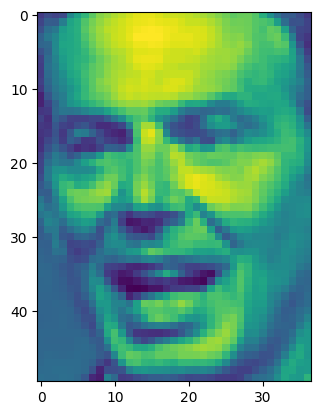

In [4]:
plt.imshow(lfw_people.images[1])
plt.show()

In [5]:
#!dir "../data/external/wind-power-generation-data"
#lfw_people.images[1][0]['imageHeight']

In [6]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # input_shape=(3, H, W)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 12 * 9, 128)  # 64 feature maps, 12x9 size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        # Ensure that the target is in the correct format (class indices) for compatibility with CrossEntropyLoss.
        data, target = data.to(device), target.to(device)
        target = target.long()  # Ensure target is of type torch.long
        if len(target.size()) > 1:
                target = target.squeeze()  # Remove extra dimensions

        #optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            target = target.long()  # Ensure target is of type torch.long
            if len(target.size()) > 1:
                target = target.squeeze()  # Remove extra dimensions
            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    return test_loss, accuracy

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
set_seed(42)  # Set your desired seed value here
    
# Hyperparameters and device setup
batch_size = 128
epochs = 50
learning_rate = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data preparation
X_train, X_test, y_train, y_test = train_test_split(lfw_people.images, lfw_people.target, test_size=0.2, random_state=42)
target_names = lfw_people.target_names

train_dataset = CustomDataset(X_train, y_train, transform_train)
test_dataset = CustomDataset(X_test, y_test, transform_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
# Initialize model, loss, and optimizer
model = CNN(num_classes=len(target_names)).to(device)
criterion = nn.CrossEntropyLoss()
for param in model.parameters():
    param.grad = None

# Training and testing loop
train_losses = []
test_losses = []
accuracies = []
patience = 3  # Number of epochs to wait for improvement
best_test_loss = float('inf')
patience_counter = 0

# Definiowanie zakresów hiperparametrów
param_space = {
    "batch_size": [32, 64, 128, 256],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001],
    "dropout_rate": [0.25, 0.5]
}

def run_experiment(params):
    # Aktualizuj dropout w modelu
    model.dropout.p = params['dropout_rate']

    # Przygotuj dataloadery z nowym batch_size
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # Aktualizuj optimizer z nowym learning_rate
    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'])

    # Trening modelu
    best_test_loss = float('inf')
    for epoch in range(epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy = evaluate(model, test_loader, criterion, device)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")
        
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), f"best_model_hyperparameter.pth")

    return best_test_loss

In [10]:
# Iteracja przez wszystkie kombinacje hiperparametrów
best_params = None
best_loss = float('inf')

for params in itertools.product(*param_space.values()):
    param_dict = dict(zip(param_space.keys(), params))
    print(f"Running experiment with params: {param_dict}")
    loss = run_experiment(param_dict)
    if loss < best_loss:
        best_loss = loss
        best_params = param_dict

print(f"Best parameters: {best_params} with loss: {best_loss}")

Running experiment with params: {'batch_size': 32, 'learning_rate': 0.1, 'dropout_rate': 0.25}
Epoch 1/50, Train Loss: 95.5701, Test Loss: 17.9603, Accuracy: 0.4341
Epoch 2/50, Train Loss: 4.3263, Test Loss: 2.7217, Accuracy: 0.1047
Epoch 3/50, Train Loss: 2.6610, Test Loss: 2.5014, Accuracy: 0.1822
Epoch 4/50, Train Loss: 3.8970, Test Loss: 4.5801, Accuracy: 0.4612
Epoch 5/50, Train Loss: 4.5185, Test Loss: 4.7924, Accuracy: 0.0426
Epoch 6/50, Train Loss: 5.9645, Test Loss: 6.0463, Accuracy: 0.0853
Epoch 7/50, Train Loss: 5.8634, Test Loss: 6.1615, Accuracy: 0.1047
Epoch 8/50, Train Loss: 5.9676, Test Loss: 7.4432, Accuracy: 0.4612
Epoch 9/50, Train Loss: 8.7156, Test Loss: 9.5493, Accuracy: 0.4612
Epoch 10/50, Train Loss: 8.9198, Test Loss: 10.0626, Accuracy: 0.0736
Epoch 11/50, Train Loss: 9.2797, Test Loss: 7.9041, Accuracy: 0.1822
Epoch 12/50, Train Loss: 9.6207, Test Loss: 10.7960, Accuracy: 0.1822
Epoch 13/50, Train Loss: 9.0793, Test Loss: 7.3330, Accuracy: 0.4612
Epoch 14/50, 